<a href="https://colab.research.google.com/github/qkrwoghd04/Image-text_fusion_for_binary_classification_using_BERT-ViT/blob/master/code/Image%26Text_fusion_using_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ops
!pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.1/164.1 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 16.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.1.1 which is incompatible.


In [2]:
!pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 46.9 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0
ERROR: pip's dependency res

In [15]:
%tensorflow_version 2.x
import os
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import keras as keras
from keras import ops
import cv2
from keras.callbacks import CSVLogger
import sys
import time
import pickle
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array, load_img
from keras.callbacks import EarlyStopping
from keras import callbacks


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [63]:
# 이미지와 패치 크기 설정
input_shape= (224,224,3)
image_size = 224
patch_size = 32
num_patches = (image_size//patch_size)**2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Transformer의 각 Dense layer의 유닛 수
transformer_layers = 8
mlp_head_units = [2048, 1024]  # 최종 분류기의 Dense layer 유닛 수


In [64]:
# 데이터 경로 및 파라미터 설정
train_data_dir = r'/content/drive/MyDrive/image_dataset/processed/train'
test_data_dir = r'/content/drive/MyDrive/image_dataset_splited/test'
nb_train_samples = 400
nb_test_samples = 40
n_classes = 2
epochs = 30
batch_size = 64

In [65]:
def load_and_preprocess_data(base_path, input_shape, classes):
    x = []
    y = []
    class_labels = {class_name: index for index, class_name in enumerate(classes)}

    for class_name in classes:
        class_dir = os.path.join(base_path, class_name)
        for img_name in os.listdir(class_dir):
            # 이미지 로드 및 리사이즈
            img_path = os.path.join(class_dir, img_name)
            img = load_img(img_path, target_size=(input_shape))
            img_array = img_to_array(img)

            # 이미지와 레이블 리스트에 추가
            x.append(img_array)
            y.append(class_labels[class_name])

    # 리스트를 NumPy 배열로 변환
    x = np.array(x)
    y = np.array(y)

    return x, y


In [66]:
classes = ['Fall', 'Sleep']

x_train, y_train = load_and_preprocess_data(train_data_dir, input_shape, classes)

x_test, y_test = load_and_preprocess_data(test_data_dir, input_shape, classes)

# 데이터 차원 확인
print(f"x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"x_test: {x_test.shape}, y_test: {y_test.shape}")

x_train: (400, 224, 224, 3), y_train: (400,)
x_test: (40, 224, 224, 3), y_test: (40,)


In [67]:
# 데이터 증강
from tensorflow import keras
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomTranslation


data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
        RandomTranslation(height_factor=0.1, width_factor=0.1), # 추가: 임의의 위치로 이동
        RandomContrast(factor=0.1), # 추가: 대비 조정
        # RandomErasing를 직접 구현하거나 찾아본 후 추가할 수 있습니다.
    ],
    name="data_augmentation",
)

data_augmentation.layers[0].adapt(x_train)

In [68]:
def mlp(x, hidden_units, dropout_rate):


  for units in hidden_units:
    x = layers.Dense(units,activation=tf.nn.gelu)(x) #GELU(Gaussian Error Linear Unit)
    x = layers.Dropout(dropout_rate)(x)
  return x

In [69]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

In [70]:
class PatchEncoder(layers.Layer):
  def __init__(self, num_patches, projection_dim):
    super().__init__()
    self.num_patches = num_patches

    self.projection = layers.Dense(units=projection_dim)
    self.position_embedding = layers.Embedding(
        input_dim = num_patches, output_dim = projection_dim
    )

  def call(self, patch):
    positions = tf.range(start=0, limit=self.num_patches, delta=1)
    encoded = self.projection(patch) + self.position_embedding(positions)
    return encoded

In [73]:
def vit():
    inputs = keras.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(2, activation='softmax')(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [86]:
model = vit()
model.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ data_augmentation         │ (None, 224, 224, 3)    │              7 │ input_layer_13[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patches_9 (Patches)       │ (None, 49, 3072)       │              0 │ data_augmentation[4][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patch_encoder_9           │ (None, 49, 64)         │        199,808 │ patches_9[0][0]        │
│ (PatchEncoder)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_153   │ (None, 49, 64)         │            128 │ patch_encoder_9[0][0]  │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_72   │ (None, 49, 64)         │         66,368 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_144 (Add)             │ (None, 49, 64)         │              0 │ multi_head_attention_… │
│                           │                        │                │ patch_encoder_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_154   │ (None, 49, 64)         │            128 │ add_144[0][0]          │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_181 (Dense)         │ (None, 49, 128)        │          8,320 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_244 (Dropout)     │ (None, 49, 128)        │              0 │ dense_181[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_182 (Dense)         │ (None, 49, 64)         │          8,256 │ dropout_244[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_245 (Dropout)     │ (None, 49, 64)         │              0 │ dense_182[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_145 (Add)             │ (None, 49, 64)         │              0 │ dropout_245[0][0],     │
│                           │                        │                │ add_144[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_155   │ (None, 49, 64)         │            128 │ add_145[0][0]          │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_73   │ (None, 49, 64)         │         66,368 │ layer_normalization_1… │
│ (MultiHeadAttention) 

 Total params: 9,390,345 (35.82 MB)

 Trainable params: 9,390,338 (35.82 MB)

 Non-trainable params: 7 (32.00 B)

In [87]:
optimizer = keras.optimizers.Adam(
        learning_rate=0.0001, weight_decay=1e-4
    )

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# checkpoint_filepath = "drive/MyDrive/tmp/checkpoint.weights.h5"
# checkpoint_callback = keras.callbacks.ModelCheckpoint(
#     checkpoint_filepath,
#     monitor="val_accuracy",
#     save_best_only=True,
#     save_weights_only=True,
# )

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=1, min_lr=0.00001)

early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=50,
    validation_split=0.2,
    callbacks = [early_stopping] # 훈련 데이터의 20%를 검증 데이터로 사용
)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 30s 542ms/step - accuracy: 0.5193 - loss: 1.4208 - val_accuracy: 0.6000 - val_loss: 0.9281
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.6338 - loss: 1.0400 - val_accuracy: 0.6125 - val_loss: 1.0643
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.6360 - loss: 1.0110 - val_accuracy: 0.6125 - val_loss: 0.9837
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.7278 - loss: 0.7212 - val_accuracy: 0.6500 - val_loss: 0.9176
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.6208 - loss: 0.9862 - val_accuracy: 0.6375 - val_loss: 0.8708
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.7362 - loss: 0.7736 - val_accuracy: 0.6750 - val_loss: 0.8014
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.7287 - loss: 0.7828 - val_accuracy: 0.7375 - val_loss: 0.7569
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.6911 - loss: 0.8785 - val_accuracy: 0.7500 - val_loss

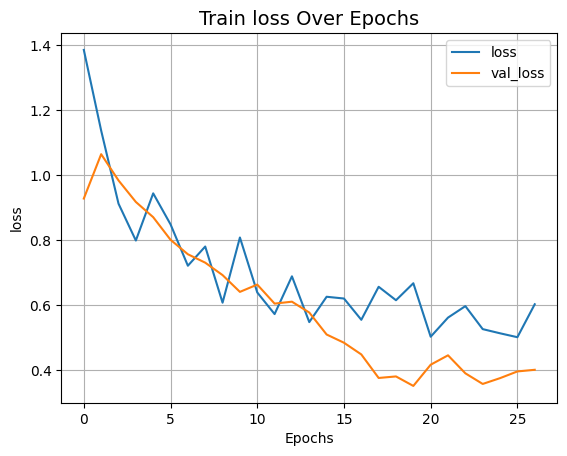

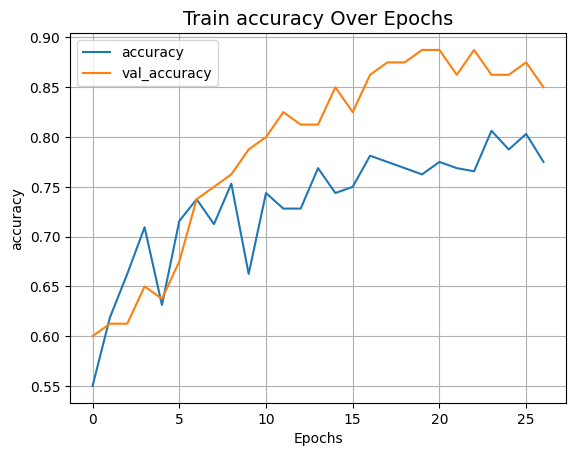

In [88]:
def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("accuracy")

In [89]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6396 - loss: 1.7578
Test Loss: 2.2288949489593506
Test Accuracy: 0.6000000238418579
